# Exploratory Data Analysis

In this notebook, we seek to investigate the conditions that are associated with higher and lower periods of volatility.

After combining the price history dataset with the economic indicators, we now have the following variables:
1. Monthly Opening Price
2. Monthly High Price
3. Monthly Low Price
4. Monthly Closing Price
5. Monthly Volume
6. Consumer Price Index
7. Unemployment
8. Consumer Confidence Index
9. Interest Rate

The goal of this exploratory data analysis is to investigate the factors that influence volatility in the S&P 500

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf

df = pd.read_csv('data/merged_df.csv')

In [146]:
# Drop the first column (usually the index column)
df.drop(df.columns[0], axis=1, inplace=True)

# Convert 'Date' to datetime, forcing errors to NaT (Not a Time) in case of issues
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Check the data type
print(df['Date'].dtype)  # Should be datetime64[ns]

df.head()

datetime64[ns]


,Date,Open,High,Low,Close,Volume,Date.1,cpi,unemployment,consumer_confidence,interest_rate
0,2015-02-01,168.072827,178.314307,166.232887,176.986862,1901638100,2015-02-01,234.722,5.5,95.4,0.11
1,2015-03-01,177.087705,178.163102,171.492275,173.433029,2749923000,2015-03-01,236.119,5.4,93.0,0.11
2,2015-04-01,174.173445,179.312821,172.586901,175.920334,2036685200,2015-04-01,236.599,5.4,95.9,0.12
3,2015-05-01,176.713593,180.409899,174.485686,178.181992,1892519900,2015-05-01,237.805,5.6,90.7,0.12
4,2015-06-01,178.857118,180.038579,173.236711,173.717743,2535242600,2015-06-01,238.638,5.3,96.1,0.13


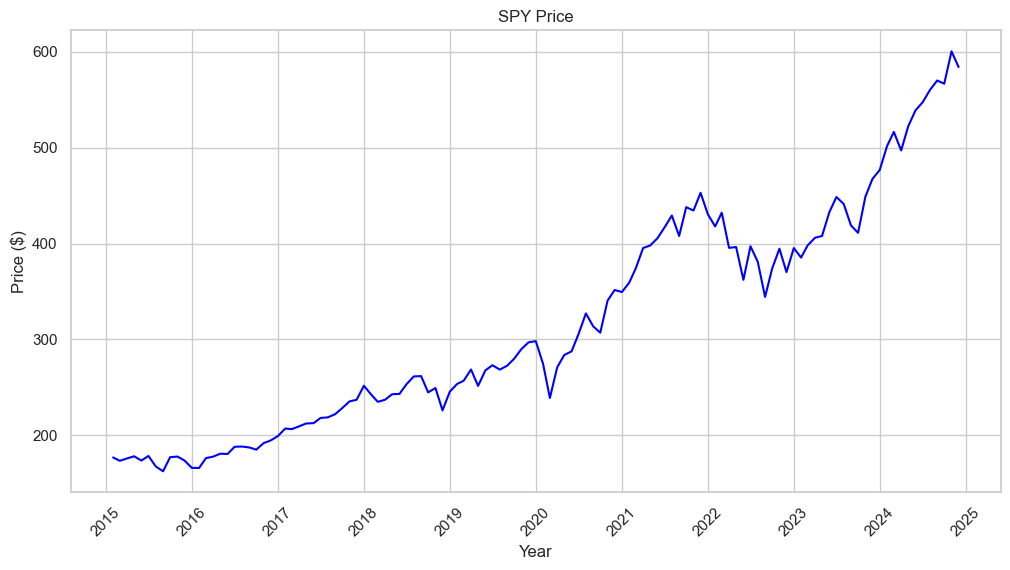

In [147]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Format x-axis to show only the year
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], color='blue')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('SPY Price')

# Rotate labels if necessary
plt.xticks(rotation=45)
plt.show()


We observe an increasingly strong increase in the price of SPY as the years go on. Most notably is the sheer strength of the rebound in prices after major pullbacks, such as in 2020 and 2023 onward.

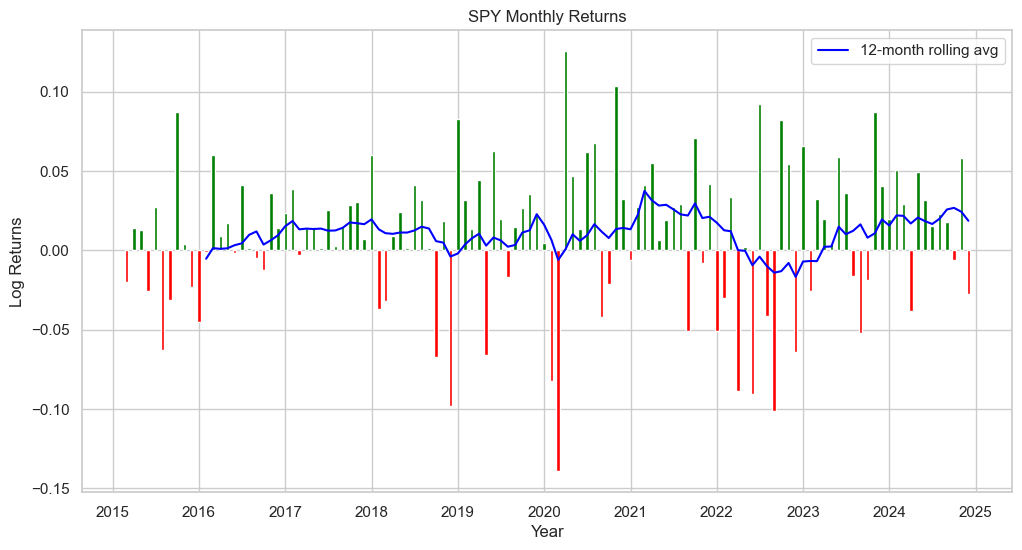

In [148]:
# Calculate log returns
sns.set(style='whitegrid')
df['log_returns'] = np.log(df['Close']) - np.log(df['Close'].shift(1))

plt.figure(figsize=(12,6))
plt.bar(df['Date'], df['log_returns'], color=['green' if r > 0 else 'red' for r in df['log_returns']], width=15)
plt.plot(df['Date'], df['log_returns'].rolling(12).mean(), color='blue', label='12-month rolling avg')
plt.xlabel('Year')
plt.ylabel('Log Returns')
plt.title('SPY Monthly Returns')
plt.legend()

In [149]:
# Add a range column
df['range'] = df['High'] - df['Low']

Text(0.5, 1.0, 'Monthly Range (High - Low)')

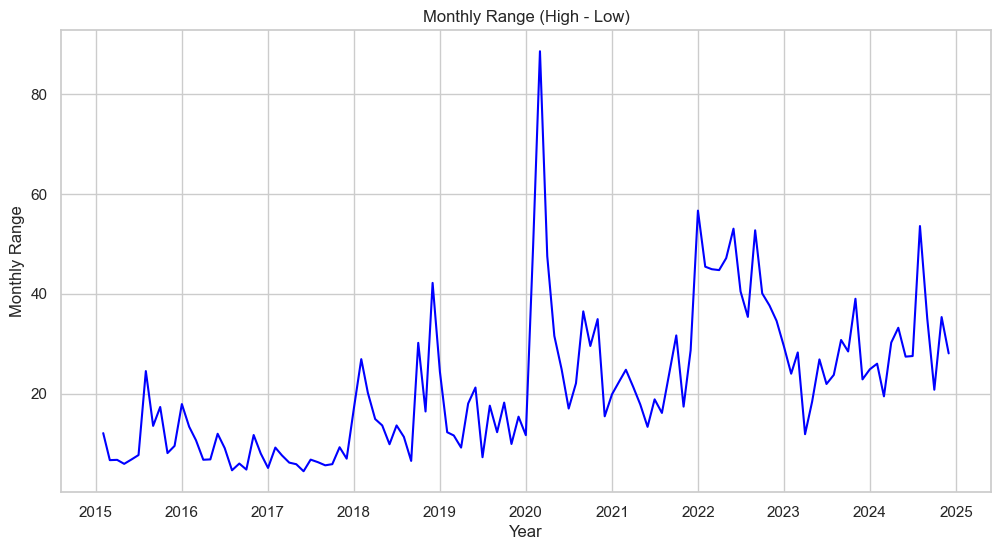

In [150]:
# Plot monthly range
sns.set(style='whitegrid')
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['range'], color='blue')
plt.xlabel('Year')
plt.ylabel('Monthly Range')
plt.title('Monthly Range (High - Low)')

The monthly range provides insight about the intra-month price dynamics. For instance, the greatest and most concentrated price swings are observed to have occurred in the early months of 2020. It is here that we see an incredibly sharp increase in the monthly range, skyrocketing up to over $80.

In [151]:
# Add rolling volatility column
window_size = 12
df['volatility'] = df['log_returns'].rolling(window_size).std()

Text(0.5, 1.0, '12-month Rolling Volatility')

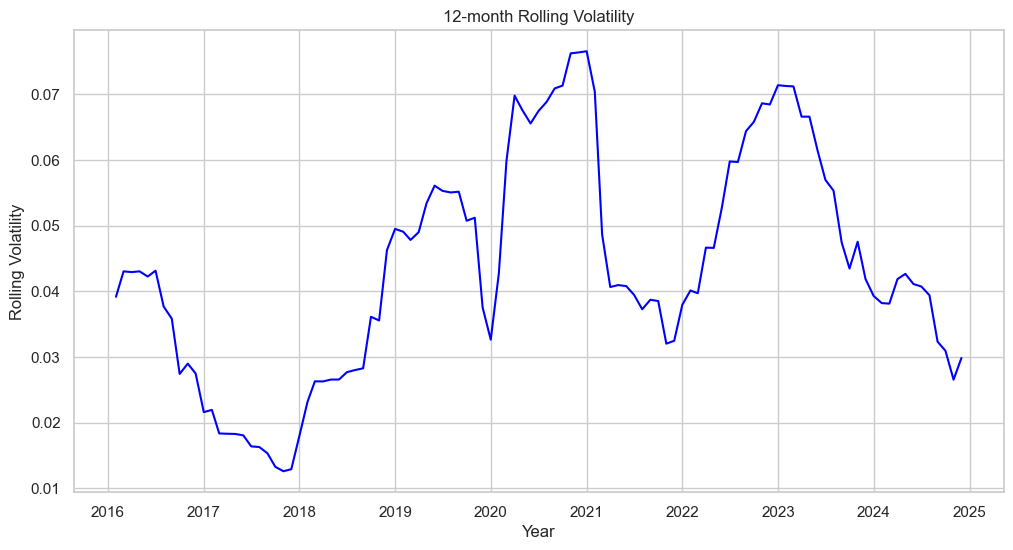

In [152]:
# Plot rolling volatility
sns.set(style='whitegrid')
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['volatility'], color='blue')
plt.xlabel('Year')
plt.ylabel('Rolling Volatility')
plt.title(f'{window_size}-month Rolling Volatility')

the 12-month rolling volatility captures the standard deviation of the log returns over the course of a year. It provides a more nuanced figure than range, and will be useful in our exploration of it.

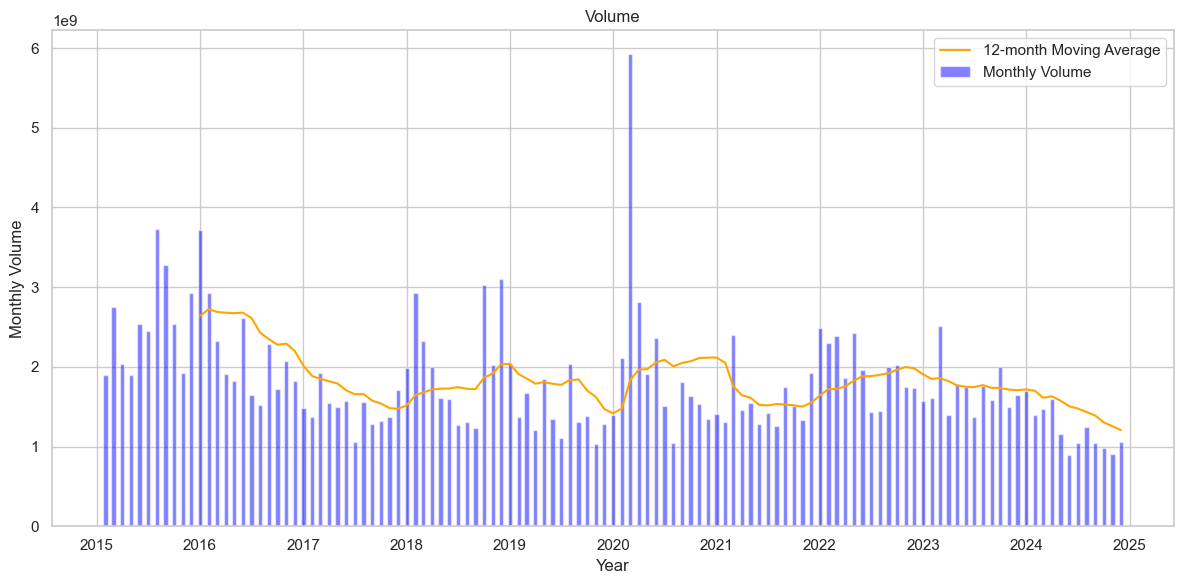

In [153]:
# Create a moving average for volume
df['volume_ma'] = df['Volume'].rolling(window=window_size).mean()

# Plot monthly volume
sns.set(style='whitegrid')

plt.figure(figsize=(12,6))
plt.bar(df['Date'], df['Volume'], color='blue', alpha=0.5, width=15, label='Monthly Volume')
plt.plot(df['Date'], df['volume_ma'], color='orange', label=f'{window_size}-month Moving Average')
plt.xlabel('Year')
plt.ylabel('Monthly Volume')
plt.title('Volume')

plt.legend()
plt.tight_layout()

We will now investigate volatility in the context of the economic data

# Investigating volatility and consumer price level

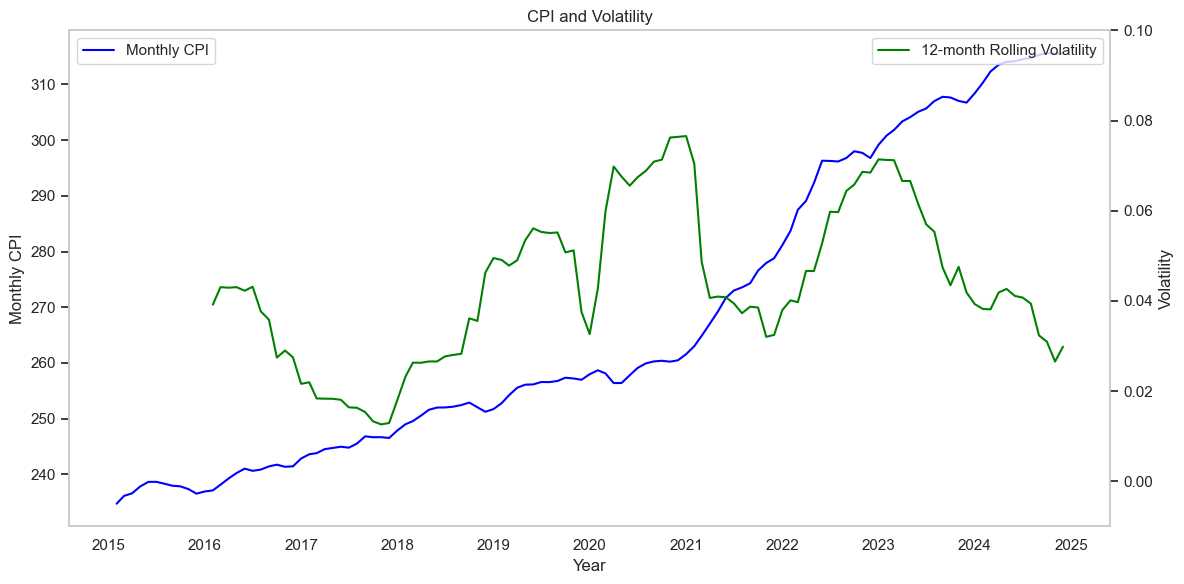

In [154]:
# Plot monthly consumer price index

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot volume on the primary y-axis
ax1.plot(df['Date'], df['cpi'], color='blue', label='Monthly CPI')
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly CPI')
ax1.legend(loc='upper left')
ax1.grid(False)

# Create a secondary y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['volatility'], color='green', label=f'{window_size}-month Rolling Volatility')
ax2.set_ylabel('Volatility')
ax2.set_ylim((-0.01,0.1))
ax2.legend(loc='upper right')
ax2.grid(False)

# Title and layout adjustments
plt.title('CPI and Volatility')
plt.tight_layout()

plt.show()


There is little striking association between CPI and volatility levels. Between 2018 and 2023, a weak but positive association is observed. However, from 2023 onward there exists a strong divergence in the values, where volatility falls as the consumer price index continues upward. 

Do note, however, that in this diverging period, the rate at which CPI increases as gone down substantially, which may explain a reduction in fear amongst investors that would be reflected in volatility. Let us investigate this relationship.

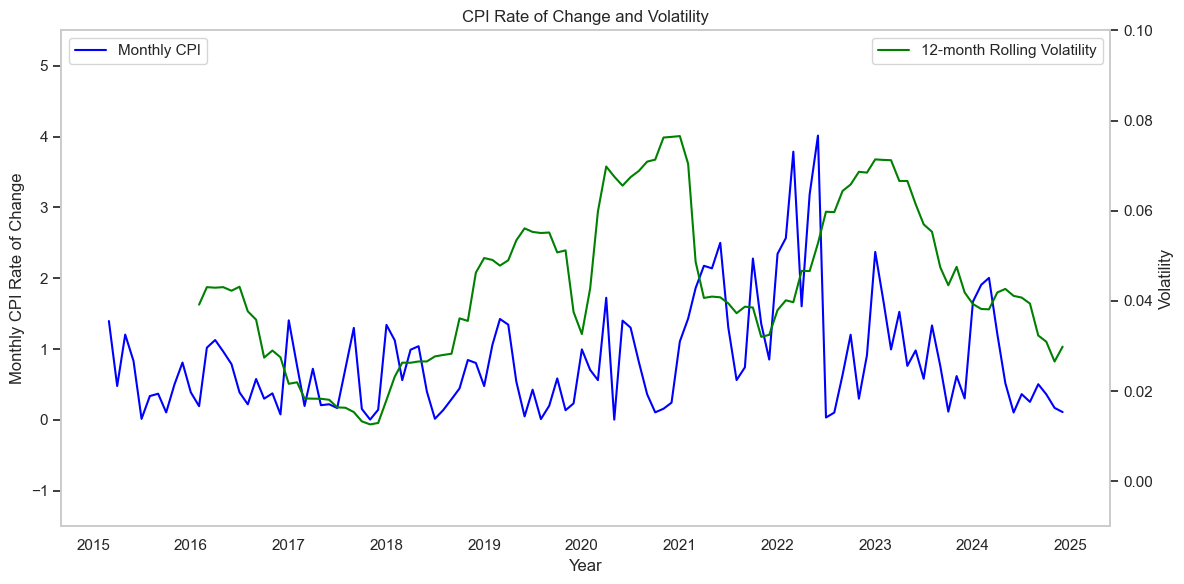

In [155]:
# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot volume on the primary y-axis
ax1.plot(df['Date'], df['cpi'].diff().abs(), color='blue', label='Monthly CPI')
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly CPI Rate of Change')
ax1.set_ylim((-1.5,5.5))
ax1.legend(loc='upper left')
ax1.grid(False)

# Create a secondary y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['volatility'], color='green', label=f'{window_size}-month Rolling Volatility')
ax2.set_ylabel('Volatility')
ax2.set_ylim((-0.01,0.1))
ax2.legend(loc='upper right')
ax2.grid(False)

# Title and layout adjustments
plt.title('CPI Rate of Change and Volatility')
plt.tight_layout()

plt.show()

In this cell, we plot the absolute value of the differences of each monthly CPI figure. This visual shows a better association, showing that volatility could be a reaction to a concerning rate of change of consumer prices, rather than a reaction to the price level itself. Observe that a stronger correlation between volatility and the rate of change of CPI is viewed during times of elevated rate of change, and less so when it is not the topic of interest.

We will look at two measures of correlation to investigate the relationship between these two variables, Spearman and Pearson correlation. Spearman measures a monotonic relationship, and Pearson assesses a linear relationship.

Because volatility is calculated with rolling historical information, its data will be shifted to better quantify relationship.
In other words, the volatility data will be shifted in such a way that its values are captured during the window for which CPI is recorded.

In [156]:
# Pearson correlation
pearson_corr = df['cpi'].corr(df['volatility'].shift(-11))
print(f"Pearson correlation: {pearson_corr:.3f}")

# Spearman correlation
spearman_corr = df['cpi'].corr(df['volatility'].shift(-11), method='spearman')
print(f"Spearman correlation: {spearman_corr:.3f}")

Pearson correlation: 0.316
Spearman correlation: 0.428


In [157]:
# Pearson correlation
pearson_corr = df['cpi'].diff().abs().corr(df['volatility'].shift(-11))
print(f"Pearson correlation: {pearson_corr:.3f}")

# Spearman correlation
spearman_corr = df['cpi'].diff().abs().corr(df['volatility'].shift(-11), method='spearman')
print(f"Spearman correlation: {spearman_corr:.3f}")

Pearson correlation: 0.250
Spearman correlation: 0.170


A central theme to keep in mind during this analysis is that volatility is a largely reactionary measure, and thus during times in which metrics like CPI are steady or normal, volatility will react to different things.

# Investigating volatility and unemployment rate

The unemployment rate is an important variable to consider when analyizing volatility. A high unemployment rate indicates that the economy is not strong enough to generate a sufficient number of jobs to meet the supply. 

Because a high unemployment rate is associated with a struggling economy, it is logical to then consider how this macroeconomic issue affects the valuations of the largest and most influential companies.

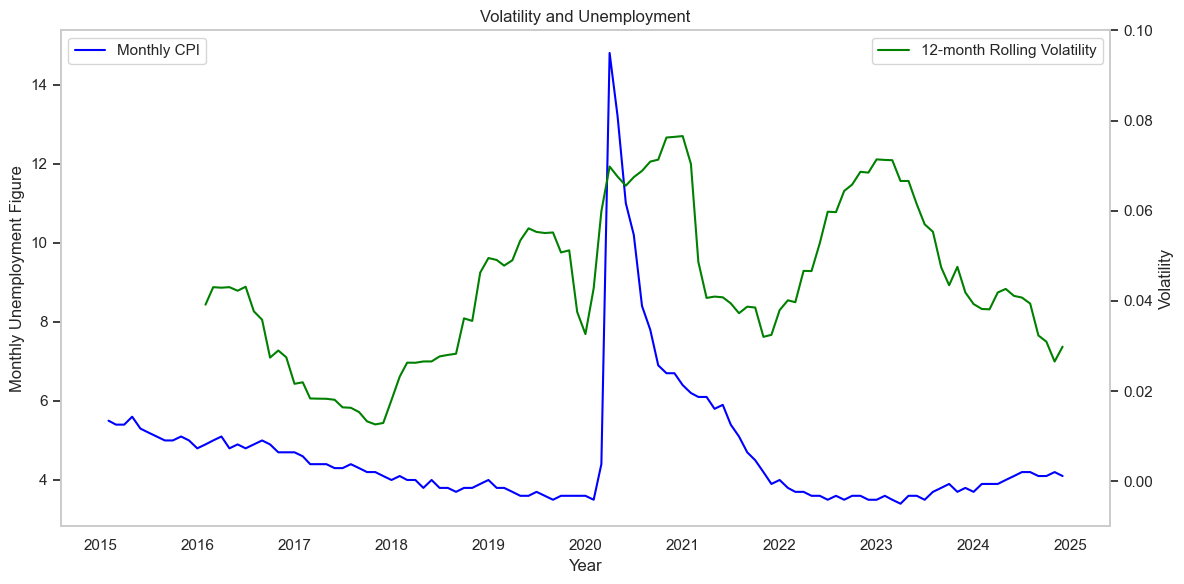

In [158]:
# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot volume on the primary y-axis
ax1.plot(df['Date'], df['unemployment'], color='blue', label='Monthly CPI')
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly Unemployment Figure')
ax1.legend(loc='upper left')
ax1.grid(False)

# Create a secondary y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['volatility'], color='green', label=f'{window_size}-month Rolling Volatility')
ax2.set_ylabel('Volatility')
ax2.set_ylim((-0.01,0.1))
ax2.legend(loc='upper right')
ax2.grid(False)

# Title and layout adjustments
plt.title('Volatility and Unemployment')
plt.tight_layout()

plt.show()

While it is quite apparent that these values do not exhibit a consistent correlation across all data points, the important detail to glean from this is that high rates of unemployment tend to coincide with higher volatility in the markets, and when unemployment is at its natural rate, volatility reacts to different things (for instance, between 2022 and 2023 the world experienced concerning levels of inflation, resulting in interest rate increases).

Additionally (taking into account the rolling volatility window), note that the sharp decrease in unemployment is followed by a sharp decrease in volatility. Even though the two are not correlated for the entire set of data, we see a logical relationship during abnormal events.

# Investigating Volatility and Consumer Confidence

Consumer Confidence is a very important indicator that conveys the optimism or pessimism that the consumer has about the economy and their own financial situation. To put the importance of this figure into perspective, according to FRED (https://fred.stlouisfed.org/series/DPCERE1Q156NBEA), personal consumption expenditures make up ~68% of the US GDP. Therefore, if the consumer is reluctant to spend money, then corporate earnings may take a hit, which translates to turbulence in the stock price.

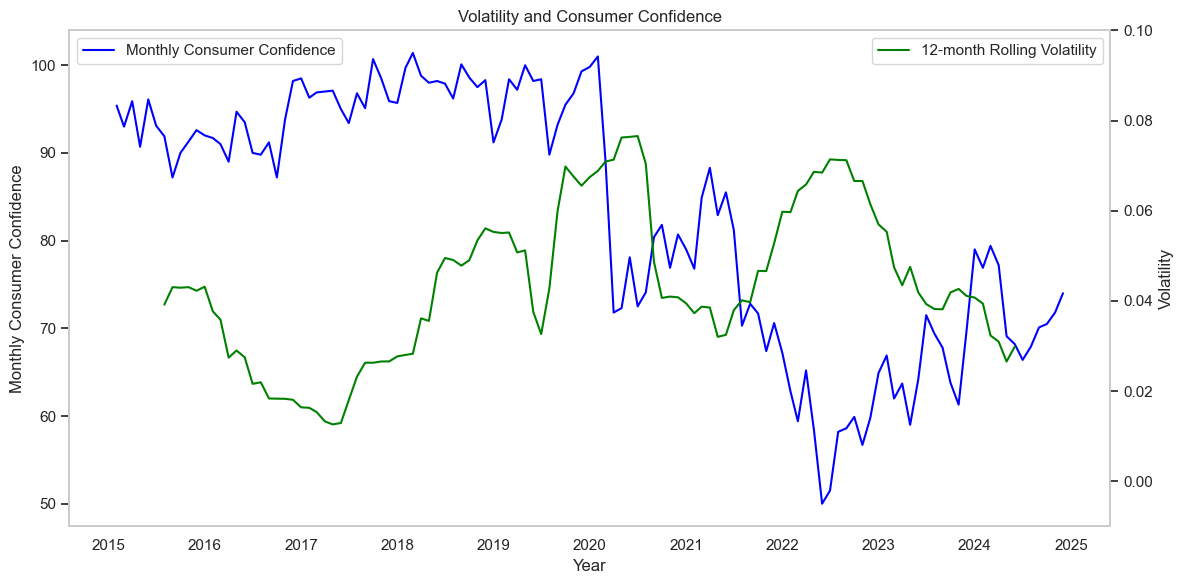

In [159]:
# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot volume on the primary y-axis
ax1.plot(df['Date'], df['consumer_confidence'], color='blue', label='Monthly Consumer Confidence')
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly Consumer Confidence')
ax1.legend(loc='upper left')
ax1.grid(False)

# Create a secondary y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['volatility'].shift(-6), color='green', label=f'{window_size}-month Rolling Volatility')
ax2.set_ylabel('Volatility')
ax2.set_ylim((-0.01,0.1))
ax2.legend(loc='upper right')
ax2.grid(False)

# Title and layout adjustments
plt.title('Volatility and Consumer Confidence')
plt.tight_layout()

plt.show()

Observe the beginning of 2020; consumer confidence dropped sharply along with volatility, signifying an inverse relationship during this time period. Additionally, between 2022 and 2024, an inverse relationship existed as well, still in line with the aforementioned rationale that low consumer confidence tends to coincide with increased volatility. 

Text(0.5, 1.0, 'Consumer Confidence vs Volatility')

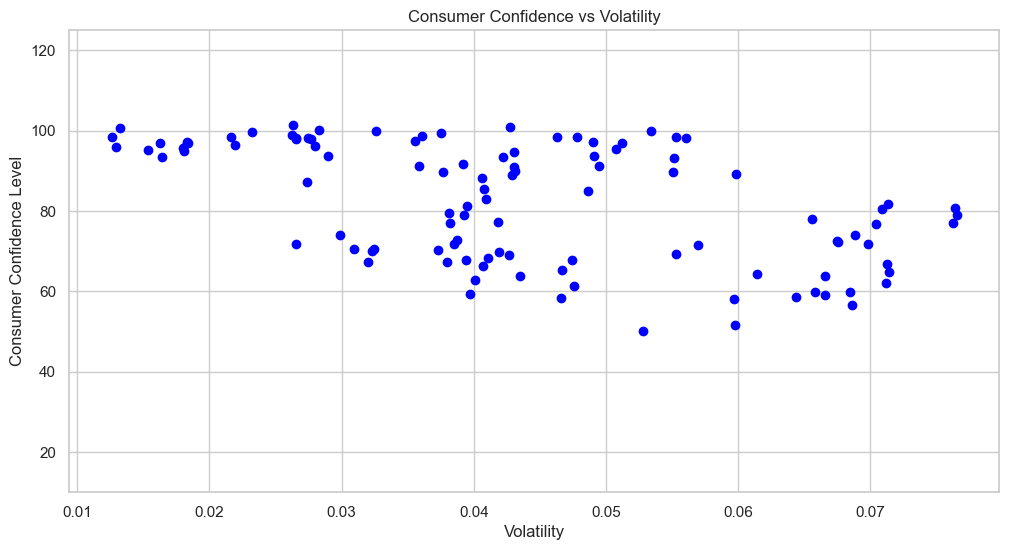

In [160]:
# Create a scatterplot
plt.figure(figsize=(12, 6))
plt.ylim((10, 125))
plt.scatter(df['volatility'], df['consumer_confidence'], color='blue')
plt.ylabel('Consumer Confidence Level')
plt.xlabel('Volatility')
plt.title('Consumer Confidence vs Volatility')

Given the event-centric nature of volatility, it is helpful in our understanding to view this relationship as a scatterplot.
Here, it seems that the relationship is a bit more clearly linear and negative.

Let us now quantify the strength of this relationship using Spearman and Pearson correlation.

In [161]:
# Pearson correlation
pearson_corr = df['consumer_confidence'].corr(df['volatility'])
print(f"Pearson correlation: {pearson_corr:.3f}")

# Spearman correlation
spearman_corr = df['consumer_confidence'].corr(df['volatility'], method='spearman')
print(f"Spearman correlation: {spearman_corr:.3f}")

Pearson correlation: -0.524
Spearman correlation: -0.505


The Spearman and Pearson correlations reveal a moderate negative correlation

# Investigating Interest Rates and Volatility

An increase in interest rates means that the cost of borrowing is increased, which thus increases the cost of investment financing, slowing economic growth. Conversely, low interest rates tend to encourage borrowing and investing as consumers and businesses take advantage of the low cost of borrowing. 

In this analysis, interest rates are taken into account to predict volatility because of the strong impact they have on businesses, which is then often reflected in the share price.

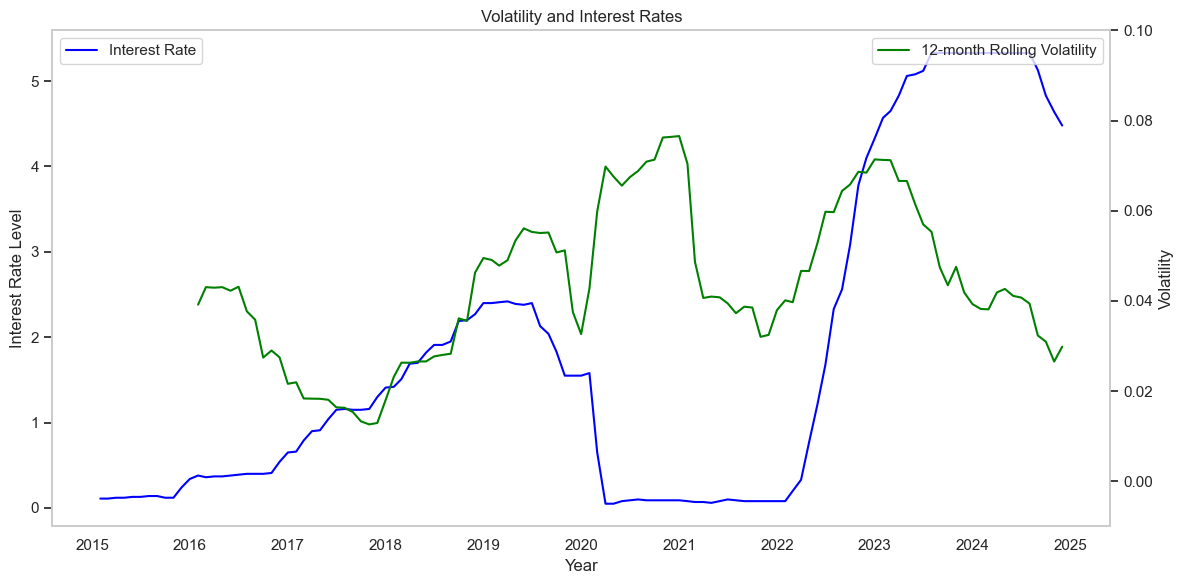

In [162]:
# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot volume on the primary y-axis
ax1.plot(df['Date'], df['interest_rate'], color='blue', label='Interest Rate')
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate Level')
ax1.legend(loc='upper left')
ax1.grid(False)

# Create a secondary y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['volatility'], color='green', label=f'{window_size}-month Rolling Volatility')
ax2.set_ylabel('Volatility')
ax2.set_ylim((-0.01,0.1))
ax2.legend(loc='upper right')
ax2.grid(False)

# Title and layout adjustments
plt.title('Volatility and Interest Rates')
plt.tight_layout()

plt.show()

When viewing this data, keep in mind that scenarios in which interest rates are very high, and scenarios in which they are very low, are likely to be of concern. On the one hand, high interest rates indicate a hot economy that is growing too quickly. Very low interest rates indicate an environment that encourages an economy at a standstill to come back to life. We view both of these extremes, and their associated periods of volatility.

In 2020, the world was shut down, and world economies grinded to a halt, thus prompting a decrease in interest rates. These low interest rates do not imply causation for the high volatility during this period, but are well-associated.

Around 2022, inflation began taking a strong toll, prompting a quick increase in interest rates. We can see here that as these interest rates skyrocketed, an increase in volatility coincided. 

Note here that when the rate hikes stopped around mid 2023, the volatility level began to come down. A likely explanation is due to the forward looking nature of the markets, seeing an end in sight to the tight fiscal policies that slowed the economy.

# Summarizing Linear Relationships

To conclude this exploratory data analysis, present a heatmap representing the linear correlation matrix of each variable in the dataset. Keep in mind that this depicts only linear relationships, and given the previous analysis, the data often tells a more nuanced story.

However, this is an excellent way to get an idea of how the feature variables interact with one another, rather than analyzing how each one performs compared to volatility.

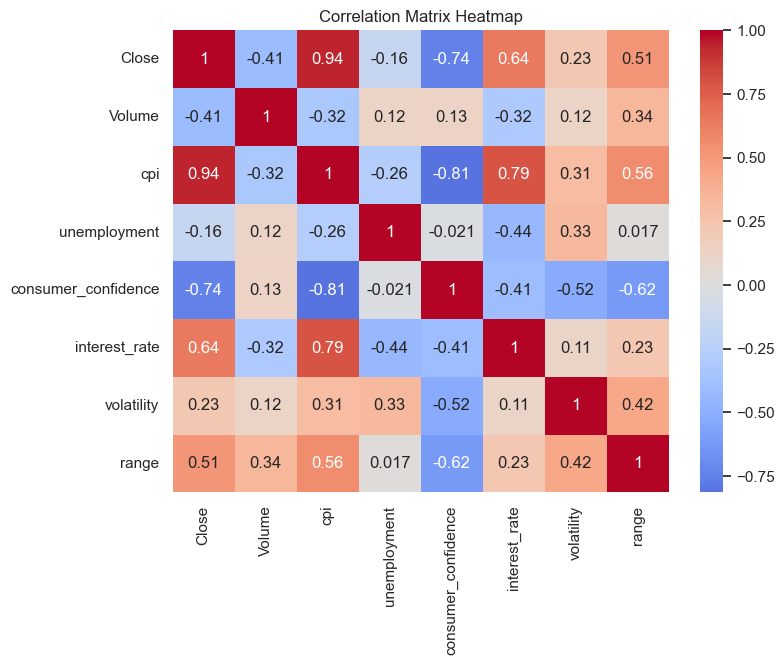

In [164]:
# Columns to make a heatmap with
cols = ['Close', 'Volume', 'cpi', 'unemployment', 'consumer_confidence', 'interest_rate', 'volatility', 'range']

# Subset of the dataframe
subset_df = df[cols]

# Correlation matrix
corr_matrix = subset_df.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()


# Notes about the heatmap
1. Observe how CPI and Interest Rate have a strong linear correlation of 0.78, this makes sense because of how higher interest rates are often used to combat higher price levels
2. Additionally, note the strong negative relationship between CPI and Consumer Confidence. Clearly an economy with soaring price levels is going to erode the confidence consumers have.
3. Finally, the closing price has an extremely strong correlation with the consumer price index. This makes sense due to the fact that they are both often reflections of a quickly growing, or 'hot' economy.